<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

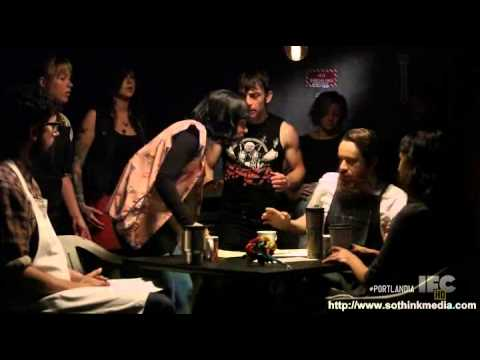

In [217]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [218]:
%pwd

'/mnt/c/Users/johnj/OneDrive/Documents/Lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [219]:
# Imports

import pandas as pd
import re


# Import data from GitHub and check it out

url = "https://raw.githubusercontent.com/johnjdailey/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [220]:
# Shape of shops dataframe

shops.shape

(7616, 3)

In [221]:
# Replace part of the string in star_rating with nothing, to remove it

shops["star_rating"] = shops["star_rating"].str.replace(".0 star rating", "")
print(shops["star_rating"].head())

0     5 
1     4 
2     4 
3     2 
4     4 
Name: star_rating, dtype: object


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [222]:
# Convert the remaining number from star_rating to numeric since it still remains type float

shops["star_rating"] = shops["star_rating"].apply(pd.to_numeric)

In [223]:
# Create a new good_or_bad column based on the star rating. Based on the Hint (1-3 is bad and 4 or 5 is good)

shops["good_or_bad"] = shops["star_rating"].apply(lambda x: "good" if x<= 4 else "bad")
print(shops["good_or_bad"].head())

0     bad
1    good
2    good
3    good
4    good
Name: good_or_bad, dtype: object


In [224]:
# Create date column with dates extracted from full_review_text column

shops['date'] = shops['full_review_text'].str.extract('(../.?./....)', expand=True)
print(shops['date'])

0       11/25/2016
1        12/2/2016
2       11/30/2016
3       11/25/2016
4        12/3/2016
           ...    
7611     2/19/2015
7612     1/21/2016
7613     4/30/2015
7614      8/2/2015
7615     5/23/2015
Name: date, Length: 7616, dtype: object


In [225]:
# Drop the dates from full_text_review column

shops['full_review_text'] = shops['full_review_text'].str.replace('(../.?./....)', "")

In [226]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,good_or_bad,date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! E...,5,bad,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Au...",4,good,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved th...,4,good,11/30/2016
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating H...,2,good,11/25/2016
4,The Factory - Cafe With a Soul,1 check-in They are located within the North...,4,good,12/3/2016


In [227]:
# Notice anything odd here? Nope!

shops['full_review_text'].value_counts()

  Love this place. I really appreciate the lack of wifi. Makes it much easier to have good conversations or lose yourself in a good book. Agree that it's a bit pricey, but the drinks are really good.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [228]:
# Make all text in full_review_text column lower case

shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.lower())
shops['full_review_text'].value_counts()

  3 check-ins this place has been shown on my social media for days so i finally visited! one of the cutest and artistic looking coffeeshops i have ever visited. you can self order which is nice because you can take your time and look at the pictures to help you decide! i especially liked how pictures were shown so i knew which coffee/tea came out aesthetically  i ordered the famous matcha green latte and i dont usually drink coffee but it went beyond my expectations. they give you a good amount and its creamy and sweet. only downside is no wifi.. so hard to study here. matcha green tea and living la vida mocha matcha green tea latte interior design see all photos from sarah l. for the factory - cafe with a soul                                                                                                                                                                                 4
  great coffee, food and atmosphere! love the set-up. order on an ipad and they call your name out w

In [229]:
# Make a tokenize function

def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    # Keep only alphanumeric characters
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [230]:
# Science for analysis

"""
Import Statements
"""

# Base

from collections import Counter
import re
import pandas as pd

# Plotting

import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries

import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [231]:
# Tokenize all of the text in full_review_text column into a new column, tokens

shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [232]:
# Show head of tokens column

shops['tokens'].head()

0    [1, checkin, love, love, loved, the, atmospher...
1    [listed, in, date, night, austin, ambiance, in...
2    [1, checkin, listed, in, brunch, spots, i, lov...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [1, checkin, they, are, located, within, the, ...
Name: tokens, dtype: object

In [233]:
# Analyze the tokens

# Object from Base Python

from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it 

word_counts = Counter()

# Update it based on a split of each of our documents

shops['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words

word_counts.most_common(10)

# Consider getting rid of some stop words

[('the', 34809),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12597),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546)]

In [235]:
# A fuction which takes a corpus of document and returns a dataframe of word counts for us to analyze

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [236]:
# Use the function to return a dataframe of word counts

wc = count(shops['tokens'])

In [237]:
# Word counts dataframe head

wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
2,the,6847,34809,1.0,0.044978,0.044978,0.899028
9,and,6864,26650,2.0,0.034436,0.079414,0.901261
26,a,6246,22755,3.0,0.029403,0.108817,0.820116
13,i,5528,20237,4.0,0.026149,0.134966,0.725840
23,to,5653,17164,5.0,0.022178,0.157144,0.742253


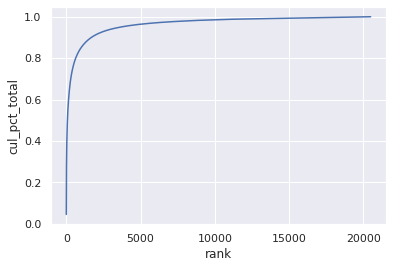

In [238]:
# Make a Cumulative Distribution Plot

import seaborn as sns

sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [239]:
# Word count rank column top 20 words as percentage of all words

wc[wc['rank'] <= 20]['cul_pct_total'].max()

0.3140958797374879

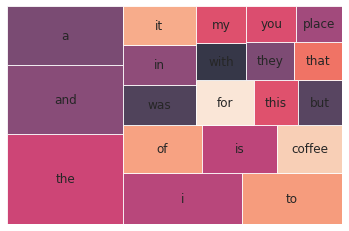

In [240]:
# Squarify plot of top 20 words as percentage of total

import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

# Consider these as stop words, most are already included by default

In [241]:
# Processing Raw Text with Spacy

import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer

tokenizer = Tokenizer(nlp.vocab)

In [242]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [243]:
# Shops token column head

shops['tokens'].head()

0    [  , 1, check-in, love, love, loved, the, atmo...
1    [  , listed, in, date, night:, austin,, ambian...
2    [  , 1, check-in, listed, in, brunch, spots, i...
3    [  , very, cool, decor!, good, drinks, nice, s...
4    [  , 1, check-in, they, are, located, within, ...
Name: tokens, dtype: object

In [244]:
# Count shops tokens

wc = count(shops['tokens'])

In [245]:
# Word counts head

wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
2,the,6847,34649,1.0,0.043235,0.043235,0.899028
9,and,6853,26442,2.0,0.032994,0.076228,0.899816
30,a,6240,22657,3.0,0.028271,0.104500,0.819328
19,,6676,20570,4.0,0.025667,0.130166,0.876576
11,i,5511,19990,5.0,0.024943,0.155110,0.723608


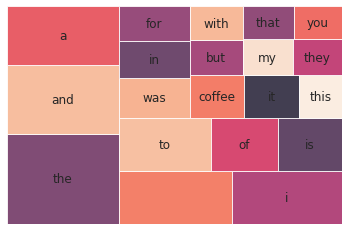

In [246]:
# Word counts top 20, again

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

# Consider these as stop words, most are already included by default

In [247]:
# Begin process to get rid of stop words

# Spacy's Default Stop Words
#nlp.Defaults.stop_words

In [248]:
# Update tokens by removing stop words

tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [249]:
shops.tokens.head()

0    [  , 1, check-in, love, love, loved, atmospher...
1    [  , listed, date, night:, austin,, ambiance, ...
2    [  , 1, check-in, listed, brunch, spots, loved...
3    [  , cool, decor!, good, drinks, nice, seating...
4    [  , 1, check-in, located, northcross, mall, s...
Name: tokens, dtype: object

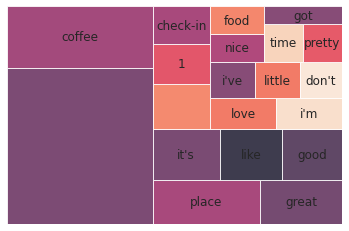

In [250]:
# Squarify plot of word count ranks

wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

# Consider these as stop words

#" ", "coffee", "place", "check-in", "1", "  ", "i'm", "i've", "got"

In [251]:
# Count of how many reviews of each rating

shops['star_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: star_rating, dtype: int64

In [252]:
# Statistical Trimming - preserve the words that give the most amount of variation in the data

# Take a look at the words at the bottom and the top

wc.tail(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
38769,delicious...and,1,1,38772.0,0.000002,0.999954,0.000131
38775,"(turkey,",1,1,38773.0,0.000002,0.999957,0.000131
38774,romaine,1,1,38774.0,0.000002,0.999959,0.000131
38773,"rib,",1,1,38775.0,0.000002,0.999961,0.000131
38776,"predictably,",1,1,38776.0,0.000002,0.999964,0.000131
38777,blts,1,1,38777.0,0.000002,0.999966,0.000131
38771,(+,1,1,38778.0,0.000002,0.999969,0.000131
38772,turkey),1,1,38779.0,0.000002,0.999971,0.000131
38778,(pork),1,1,38780.0,0.000002,0.999973,0.000131
38780,roomier,1,1,38781.0,0.000002,0.999976,0.000131


In [253]:
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
10,,6676,20570,1.0,0.049667,0.049667,0.876576
45,coffee,4210,8058,2.0,0.019456,0.069123,0.552784
159,place,3029,4264,3.0,0.010296,0.079419,0.397715
112,great,2438,3250,4.0,0.007847,0.087266,0.320116
258,it's,2061,3117,5.0,0.007526,0.094792,0.270614
177,like,2034,2902,6.0,0.007007,0.101799,0.267069
176,good,2084,2779,7.0,0.006710,0.108509,0.273634
16,,2192,2335,8.0,0.005638,0.114147,0.287815
21,1,1998,2035,9.0,0.004914,0.119060,0.262342
5,check-in,1957,1961,10.0,0.004735,0.123795,0.256959


In [254]:
# Statistical description of appears_in_pct

wc['appears_in_pct'].describe()

count    38791.000000
mean         0.001227
std          0.008809
min          0.000131
25%          0.000131
50%          0.000131
75%          0.000394
max          0.876576
Name: appears_in_pct, dtype: float64

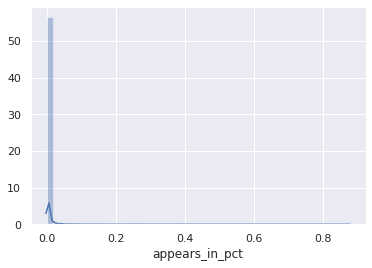

In [255]:
# Frequency of appearances in documents

sns.distplot(wc['appears_in_pct']);

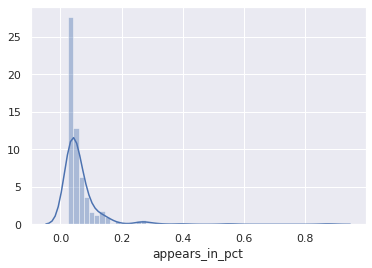

In [256]:
# Tree-Map w/ words that appear in at least 2.5% of documents

wc = wc[wc['appears_in_pct'] >= 0.025]

sns.distplot(wc['appears_in_pct']);

In [257]:
# Explore stop words

print(type(nlp.Defaults.stop_words))

<class 'set'>


In [258]:
# Extending stop words

STOP_WORDS = nlp.Defaults.stop_words.union([" ", "coffee", "coffee.", "place", "check-in", "check-ins", "1", "  ", "i'm", "i've", "got", "it's", "-", "austin",])

In [259]:
# See stop words

STOP_WORDS

{' ',
 '  ',
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '-',
 '1',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'austin',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'check-in',
 'check-ins',
 'coffee',
 'coffee.',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',

In [260]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

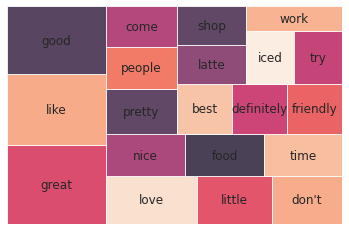

In [261]:
# Squarify plot of word count ranks

wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

# Consider these as stop words:

# "it's", "-", "austin",

In [262]:
# Create good_shops object with rating 4 or better for further analysis

good_shops = shops[shops["star_rating"]>=4]

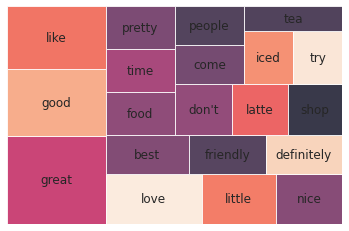

In [263]:
# Squarify plot of good shops word count ranks

wc = count(good_shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [264]:
# Create bad_shops object with rating 3 or worse for further analysis

bad_shops = shops[shops["star_rating"]<=3]

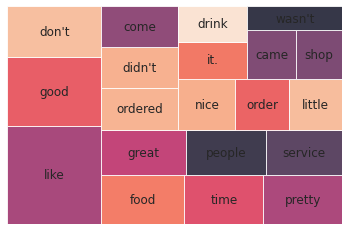

In [265]:
# Squarify plot of bad shops word count ranks

wc = count(bad_shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [266]:
# Count the good words from the good_shops

good_word_counts = Counter()

good_shops['tokens'].apply(lambda x: good_word_counts.update(x))

# Print out the 50 most common words

good_word_counts.most_common(50)

[('great', 2902),
 ('good', 2180),
 ('like', 2068),
 ('love', 1604),
 ('little', 1230),
 ('nice', 1101),
 ('best', 1093),
 ('friendly', 1014),
 ('definitely', 1002),
 ('food', 994),
 ('time', 994),
 ('pretty', 990),
 ("don't", 965),
 ('latte', 949),
 ('shop', 910),
 ('come', 908),
 ('people', 896),
 ('iced', 879),
 ('try', 867),
 ('tea', 801),
 ('work', 790),
 ('staff', 788),
 ('super', 767),
 ('parking', 745),
 ('breakfast', 717),
 ('coffee,', 702),
 ('seating', 678),
 ('delicious', 664),
 ('&', 661),
 ('favorite', 632),
 ('it.', 621),
 ("you're", 607),
 ('service', 599),
 ('drink', 595),
 ('ordered', 585),
 ('small', 584),
 ('know', 582),
 ('lot', 577),
 ('spot', 573),
 ('want', 572),
 ('think', 556),
 ('perfect', 555),
 ('sweet', 552),
 ('bit', 538),
 ('came', 538),
 ('2', 537),
 ('drinks', 535),
 ('gelato', 529),
 ('cream', 522),
 ('milk', 519)]

In [267]:
# Count the bad words from the bad_shops

bad_word_counts = Counter()

bad_shops['tokens'].apply(lambda x: bad_word_counts.update(x))

# Print out the 50 most common words

bad_word_counts.most_common(50)

[('like', 834),
 ('good', 599),
 ("don't", 430),
 ('food', 369),
 ('time', 351),
 ('pretty', 349),
 ('great', 348),
 ('people', 327),
 ('service', 314),
 ('ordered', 296),
 ("didn't", 292),
 ('come', 285),
 ('nice', 267),
 ('order', 253),
 ('little', 249),
 ('it.', 232),
 ('drink', 222),
 ('came', 214),
 ('shop', 205),
 ("wasn't", 204),
 ('love', 202),
 ('work', 201),
 ('know', 196),
 ('asked', 194),
 ('think', 186),
 ('better', 184),
 ('want', 184),
 ('coffee,', 183),
 ('drinks', 181),
 ('going', 180),
 ("you're", 179),
 ('small', 177),
 ('try', 175),
 ('latte', 175),
 ('went', 174),
 ('staff', 173),
 ('tea', 171),
 ('barista', 167),
 ('parking', 167),
 ('iced', 165),
 ('maybe', 162),
 ('bit', 156),
 ('said', 156),
 ('way', 153),
 ('definitely', 152),
 ('customer', 152),
 ('espresso', 151),
 ('lot', 150),
 ('breakfast', 148),
 ('taste', 145)]

## Can we visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [268]:
# Get items to return a tuple of lookup values

import operator

good_words = sorted(good_word_counts.items(), key=operator.itemgetter(1),reverse=True)

In [269]:
# Get items to return a tuple of lookup values

bad_words = sorted(bad_word_counts.items(), key=operator.itemgetter(1),reverse=True)

In [270]:
# Make objects for top 10 good words

good_words = good_words[:10]

In [271]:
# Make objects for top 10 bad words

bad_words = bad_words[:10]

In [272]:
# Pair good words with values for plot

good_word = []
good_value = []

for pair in good_words:
    good_word.append(pair[0])
    good_value.append(pair[1])

In [273]:
# Pair bad words with values for plot

bad_word = []
bad_value = []

for pair in bad_words:
    bad_word.append(pair[0])
    bad_value.append(pair[1])

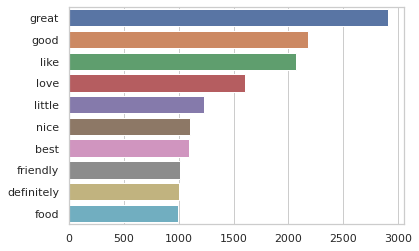

In [300]:
# Plot good words

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(y=good_word, x=good_value)

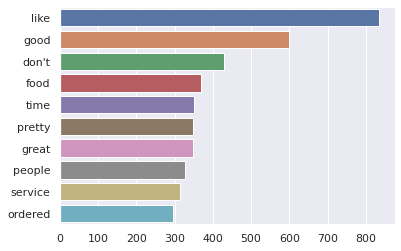

In [275]:
# Plot bad words

sns.set(style="darkgrid")
ax = sns.barplot(y=bad_word, x=bad_value)

In [276]:
# Count of how many reviews of each rating, again

shops['star_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: star_rating, dtype: int64

In [280]:
# Total good reviews

good_review_count = 3780+2360
good_review_count

6140

In [281]:
# Total bad reviews

bad_review_count = 738+460+287
bad_review_count

1485

In [286]:
# Total reviews

total_reviews = good_review_count + bad_review_count
total_reviews

7625

In [295]:
# Good word ratio to total number of good reviews

good_ratio = good_review_count/total_reviews
good_ratio

0.8052459016393443

In [305]:
# Good word relative frequency to total number of reviews

good_rel_freq_val = [i * good_ratio for i in good_value]
print(good_rel_freq_val)

[2336.823606557377, 1755.4360655737705, 1665.248524590164, 1291.6144262295081, 990.4524590163935, 886.5757377049181, 880.1337704918033, 816.5193442622951, 806.856393442623, 800.4144262295082]


In [306]:
# Bad word ratio to total number of good reviews

bad_ratio = bad_review_count/total_reviews
bad_ratio

0.19475409836065574

In [307]:
# Bad word relative frequency to total number of reviews

bad_rel_freq_val = [i * bad_ratio for i in bad_value]
print(bad_rel_freq_val)

[162.42491803278688, 116.65770491803279, 83.74426229508197, 71.86426229508197, 68.35868852459016, 67.96918032786886, 67.7744262295082, 63.68459016393443, 61.1527868852459, 57.6472131147541]


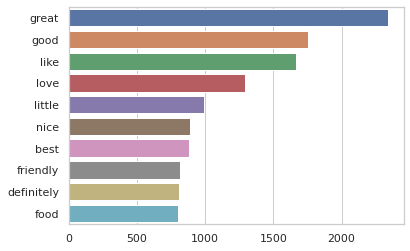

In [308]:
# Plot good words with relative frequency

sns.set(style="whitegrid")
ax = sns.barplot(y=good_word, x=good_rel_freq_val)

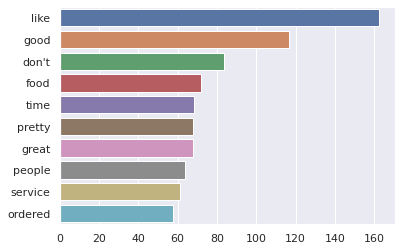

In [310]:
# Plot bad words with relative frequency

sns.set(style="darkgrid")
ax = sns.barplot(y=bad_word, x=bad_rel_freq_val)

In [314]:
# Predominately good words

predom_good_words = set(good_word) - set(bad_word)
predom_good_words

{'best', 'definitely', 'friendly', 'little', 'love', 'nice'}

In [315]:
# Predominately bad words

predom_bad_words = set(bad_word) - set(good_word)
predom_bad_words

{"don't", 'ordered', 'people', 'pretty', 'service', 'time'}

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 



In [ ]:
# Okay, I will try